In [189]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

sns.set_context('paper',font_scale=1.5)
sns.set_style('ticks')

# `defermi` introduction

`defermi` is a Python package for the calculation and analysis of point defect equilibria.\
The core object of the library is the `DefectsAnalysis` class, which handles a list of individual point defects calculations (`DefectEntry` objects).\
The class can be initialized from a `DataFrame` object, a directory containing `VASP` calculations, or by creating `DefectEntry` objects manually.
The minimal approach is to initialize the class with a `DataFrame`.  Columns are:
- `name` : Name of the defect, naming conventions described below.
- `charge` : Defect charge.
- `multiplicity` : Multiplicity in the unit cell.
- `energy_diff` : Energy of the defective cell minus the energy of the pristine cell in eV.
- `bulk_volume` : Pristine cell volume in $\mathrm{\AA^3}$

Defect naming: (element = $A$)
- `Vacancy`: `'Vac_A'` (symbol=$V_{A}$)
- `Interstitial`: `'Int_A'` (symbol=$I_{A}$)
- `Substitution`: `'Sub_B_on_A'` (symbol=$B_{A}$)
- `Polaron`: `'Pol_A'` (symbol=${A}_{A}$)

Let's create an example `DataFrame` with <span style="color:red"> made-up energies </span> as an example. We are studying $SrO$ and have energies for the neutral and charged $Sr$ and $O$ vacancies.

In [190]:
import pandas as pd

bulk_volume = 800 # cubic Amstrong

data_dict = [
{'name': 'Vac_O',
  'charge': 2,
  'multiplicity': 1,
  'energy_diff': 7,
  'bulk_volume': bulk_volume},

 {'name': 'Vac_Sr',
  'charge': -2,
  'multiplicity': 1,
  'energy_diff': 8,
  'bulk_volume': bulk_volume},

 {'name': 'Vac_O',
 'charge':0,
 'multiplicity':1,
 'energy_diff': 10.8, 
 'bulk_volume': bulk_volume},

 {'name': 'Vac_Sr',
  'charge': 0,
  'multiplicity': 1,
  'energy_diff': 7.8,
  'bulk_volume': bulk_volume},
  ]

df = pd.DataFrame(data_dict)
df

,name,charge,multiplicity,energy_diff,bulk_volume
0,Vac_O,2,1,7.0,800
1,Vac_Sr,-2,1,8.0,800
2,Vac_O,0,1,10.8,800
3,Vac_Sr,0,1,7.8,800


### create `DefectsAnalysis` object

We create the `DefectsAnalysis` object from the dataframe. Also importing from a file (`pkl` or `csv`) is possible.\
To initialize it, we also need the band gap and valence band maximum energy (in eV) of the pristine material.

In [191]:
from defermi import DefectsAnalysis

vbm = 0 # eV
band_gap = 2 # eV
 
da = DefectsAnalysis.from_dataframe(df,band_gap=band_gap,vbm=vbm)
da

,name,delta atoms,charge,multiplicity,corrections
0,Vac_O,{'O': -1},0,1,{}
1,Vac_O,{'O': -1},2,1,{}
2,Vac_Sr,{'Sr': -1},-2,1,{}
3,Vac_Sr,{'Sr': -1},0,1,{}


The `DefectsAnalysis` object is essentially a collection of `DefectEntry` objects and is subscriptable and iterable like a list:

In [192]:
for entry in da:
    print(entry.__repr__())

print('')
print(da[1])

DefectEntry: Name=Vac_O, Charge=0
DefectEntry: Name=Vac_O, Charge=2
DefectEntry: Name=Vac_Sr, Charge=-2
DefectEntry: Name=Vac_Sr, Charge=0

DefectEntry
Defect: Defect: type=Vacancy, species=O, charge=2
Energy: 7.0000
Corrections: 0.0000
Charge: 2.0
Multiplicity: 1
Data: []
Name: Vac_O




The object can be converted back to a `DataFrame` and exported as `json`, `pickle` or `csv`. 

In [193]:
# da.to_file?
da.to_dataframe()

,name,charge,multiplicity,energy_diff,bulk_volume
0,Vac_O,0,1,10.8,800
1,Vac_O,2,1,7.0,800
2,Vac_Sr,-2,1,8.0,800
3,Vac_Sr,0,1,7.8,800


## Formation energies

Formation energies of point defects are usually plotted as a function of the Fermi level. When multiple charges states are present, only the one with lowest energy is shown. The points where the most stable charge changes are called "charge transition levels", and are shown as stars in the plot.\
The plots are produced with the `plot_formation_energies` function. To compute formation energies, we need to define the chemical potentials of the elements. They can be provided as a dictionary.

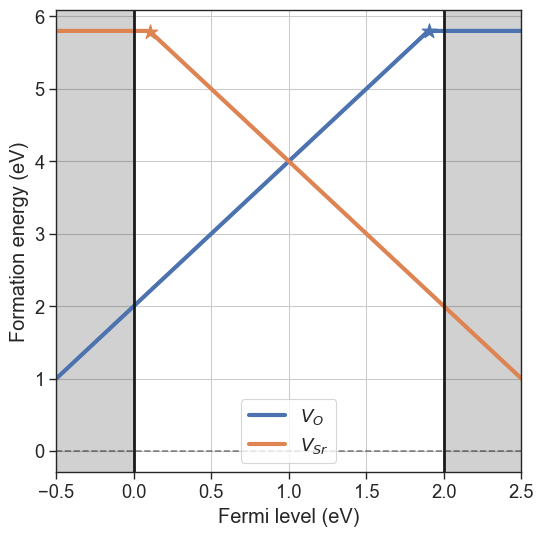

In [194]:
chempots = {'O': -5, 'Sr': -2} # made-up numbers in eV
plt = da.plot_formation_energies(chempots);

`defermi` also offers the possibility to pull the chemical potentials from the phase diagrams in the Materials Project database computed with density functional theory (GGA functionals).\
We just need to provide the target phase, and boundary regions of stability are automatically computed.

<span style="color:red"> IMPORTANT </span>:\
The automatic chemical potentials are useful to have an indication on the defects behaviour. For accurate analysis you should always define them accurately.

Pulling chemical potentials from Materials Project database...
Chemical potentials:
                 Sr          O
O-poor   -1.689493 -11.102143
O-middle -4.535489  -8.256147
O-rich   -7.381485  -5.410151


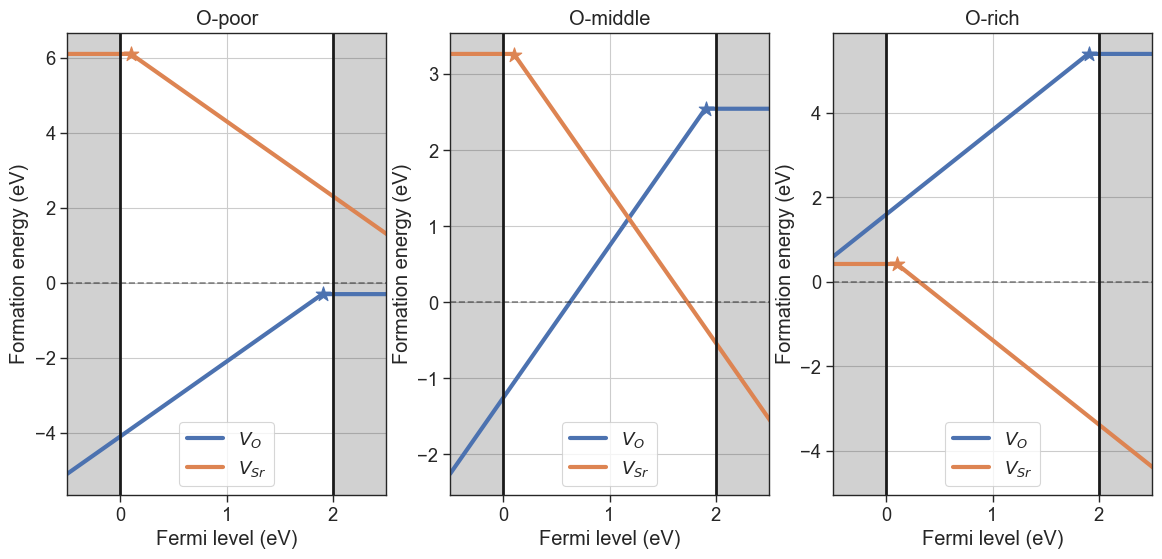

,Sr,O
O-poor,-1.689493,-11.102143
O-middle,-4.535489,-8.256147
O-rich,-7.381485,-5.410151


In [195]:
plt = da.plot_formation_energies('SrO',figsize=(14,6));
plt.show()

# Chemical potentials are stored in the chempots attribute
da.chempots

Alternatively, we can provide the target phase and a condition (`'rich'`,`'middle'` or `'poor'`) to obtain only a specific set of chemical potentials.

Pulling chemical potentials from Materials Project database...
Chemical potentials for composition = SrO and condition = O-middle:
{'Sr': -4.535489, 'O': -8.256147}


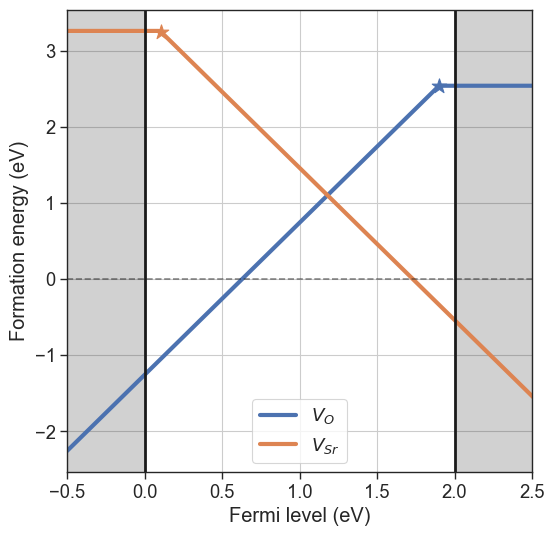

In [196]:
plt = da.plot_formation_energies(('SrO','O-middle'),figsize=(6,6));
plt.show()

## Charge transition levels

Charge transition levels are indipendent of chemical potentials and can be plotted separately. 

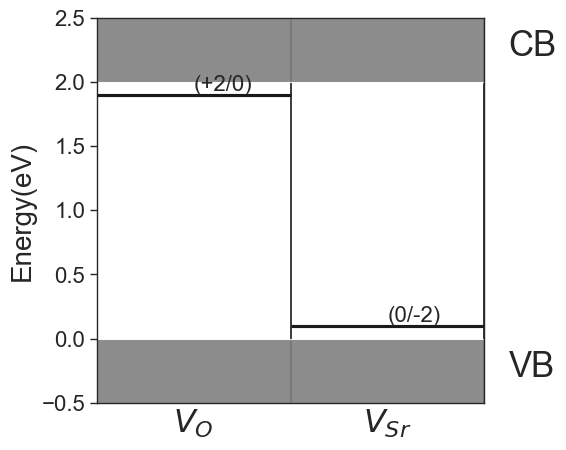

In [197]:
da.plot_ctl(figsize=(5,5));

# Fermi level dictated by charge neutrality

The defect concentrations in thermodynamic equilibrium is dictated by the position of the Fermi level (chemical potential of electrons), which in turn is determined by the charge neutrality condition (sum of all charges is zero). We can compute the equilibrium Fermi level with the `solve_fermi_level` method. We need also to provide either the effective masses of electrons and holes, or the density of states (DOS) of the pristine material for the integration of charge carriers. Defect concentrations are computed with the `defect_concentrations` method.

In [198]:
bulk_dos = {'m_eff_e': 0.5, 'm_eff_h': 0.4} # made-up effective masses
T = 1000 # Temperature = 1000 K
equilibrium_fermi_level = da.solve_fermi_level(chemical_potentials=chempots,bulk_dos=bulk_dos,temperature=T)
print(f'Fermi level dictated by charge neutrality: {equilibrium_fermi_level:.3f} eV \n')

# get equilibrium concentrations
equilibrium_concentrations = da.defect_concentrations(chemical_potentials=chempots,temperature=T,fermi_level=equilibrium_fermi_level)
print(f'Equilibrium defect concentrations in cm^-3:\n{equilibrium_concentrations}')


Fermi level dictated by charge neutrality: 0.986 eV 

Equilibrium defect concentrations in cm^-3:
[charge=0.0, conc=7.35e-09, name=Vac_O
charge=2.0, conc=1.21e+01, name=Vac_O
charge=-2.0, conc=6.20e+00, name=Vac_Sr
charge=0.0, conc=7.35e-09, name=Vac_Sr]


# Brouwer diagram

For oxides, defect concentrations are measured as a function of the oxygen partial pressure, and represented in the so-called "Brouwer diagrams". The chemical potential of oxygen is related to the partial pressure. For each partial pressure, a set of chemical potentials is determined and charge neutrality is solved.\
Brouwer diagrams are computed with the `plot_brouwer_diagram` method. The chemical potential of $Sr$ in this case is determined by the energy of the pristine material $SrO$. We need to provide also the value of $\mu_O$ at $0$ K and standard pressure $p_0$. The results of the calculation are stored in the `thermodata` attribute.\
Like for the formation energies, we can pull the target phase data and oxygen reference chemical potential from the materials project for explorative calculations.


Pulling precursors energies from Materials Project database


Retrieving ThermoDoc documents: 100%|██████████| 1/1 [00:00<00:00, 28728.11it/s]


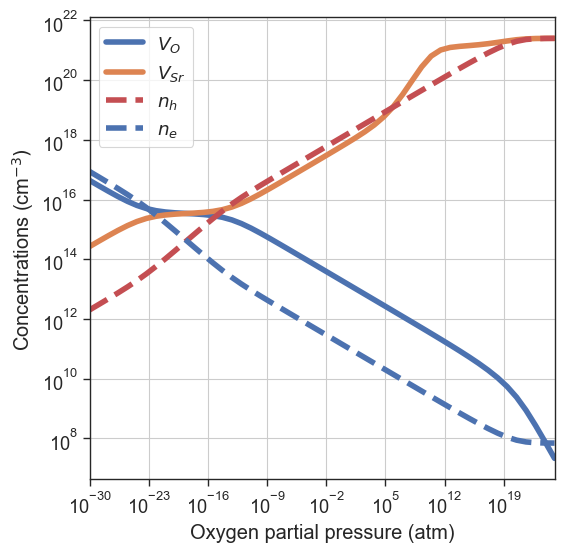

In [199]:
# Pull data from Materials Project
precursors = 'SrO'
oxygen_ref = None

da.plot_brouwer_diagram(
                    bulk_dos=bulk_dos,
                    temperature=1000,
                    precursors=precursors,
                    oxygen_ref=oxygen_ref,
                    figsize=(6,6),
                    pressure_range=(1e-30,1e25));

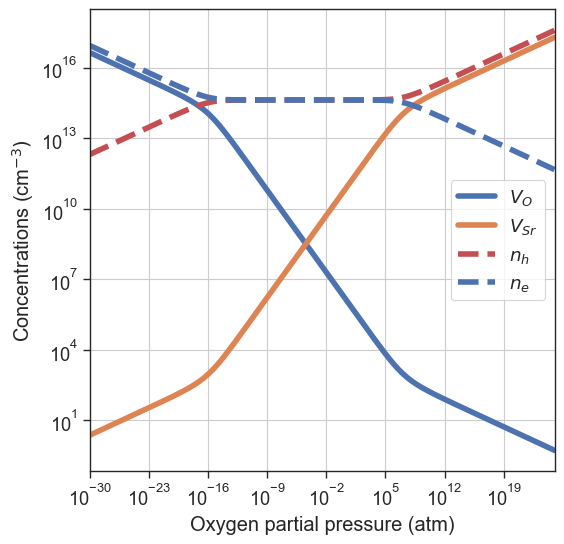

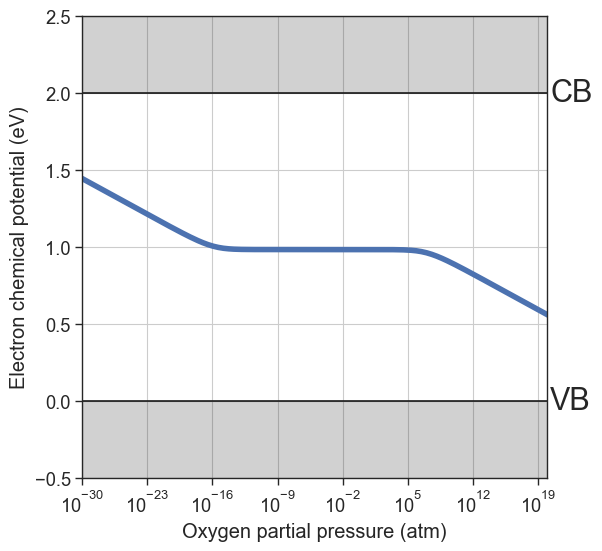

In [200]:
#or providing the data oruselves

precursors = {'SrO':-10} # made-up energy per formula unit in eV of target material or synthesis precursors
oxygen_ref = -4.95 # eV - O reference chemical potential at 0 K and standard pressure, obtained with DFT (GGA)

da.plot_brouwer_diagram(
                    bulk_dos=bulk_dos,
                    temperature=1000,
                    precursors=precursors,
                    oxygen_ref=oxygen_ref,
                    figsize=(6,6),
                    pressure_range=(1e-30,1e25),
                    npoints=200);


# Plot equilibrium Fermi level position as a function of the oxygen partial pressure
from defermi.plotter import plot_pO2_vs_fermi_level
data = da.thermodata
equilirbium_data = data #store for later

plot_pO2_vs_fermi_level(
                    partial_pressures=data.partial_pressures,
                    fermi_levels=data.fermi_levels,
                    band_gap = da.band_gap,
                    figsize=(6,6),
                    xlim=(1e-30,1e20));

### Customize plots

We can cutomize the plots by passing the arguments as `kwargs` to the `plot_brouwer_diagram` method, or by using the plotting functions individually:

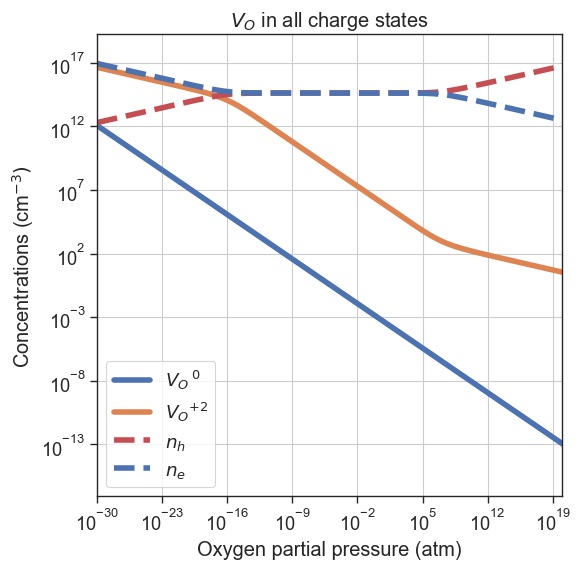

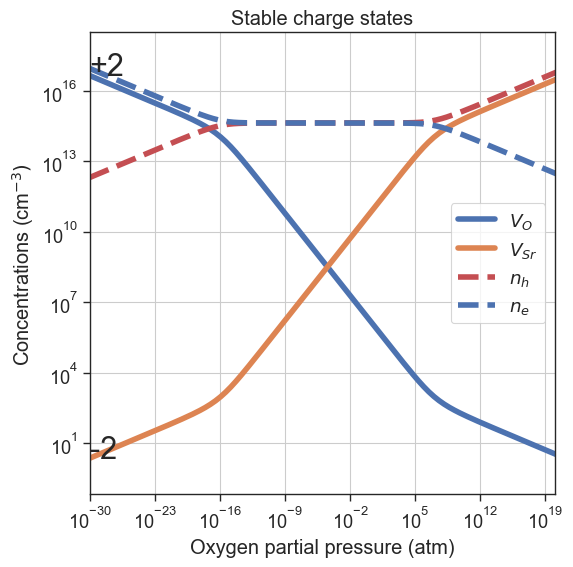

In [201]:
import matplotlib


from defermi.plotter import plot_pO2_vs_concentrations

xlim= (1e-30,1e20)

# Plot only Vac_O in all charge states
plt = plot_pO2_vs_concentrations(
                    thermodata=data,
                    output='all',
                    xlim=xlim,
                    name='Vac_O',
                    figsize=(6,6))
plt.title('$V_O$ in all charge states')

plt.show()

# Plot only most stable charge state
plt = plot_pO2_vs_concentrations(
                    thermodata=data,
                    output='stable',
                    xlim=xlim,
                    figsize=(6,6))
plt.title('Stable charge states');

## Extrinsic defects

We can also include external defects (not present in defect entries) to the calcualtion. Each additional defect is passed as a dictionary with keys:`'name'`, `'charge'`, `'conc'`. In this example we pass a defect called 'Impurity' with a charge of $-1$ and a concentration of $10^{15} \text{cm}^{-3}$.

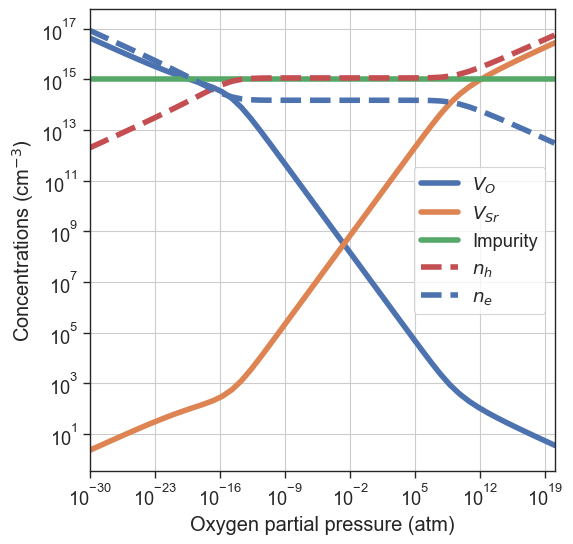

In [202]:
plt = da.plot_brouwer_diagram(
                        bulk_dos=bulk_dos,
                        temperature=1000,
                        external_defects = [{'name':'Impurity','charge':-1, 'conc':1e15}],
                        precursors=precursors,
                        oxygen_ref=-4.95,
                        figsize=(6,6),
                        pressure_range=(1e-30,1e20));

# Doping diagrams

To understand the influence of doping on the material, we can plot the equilibirum concentrations as a function of the dopant concentrations. The dopant element can either be present in the defect entries or be an external defect. If present in entries (a `Substitution` defect for example), the total concentration is fixed to a target value, but the charge states are determined by the relative formation energies. In this example, we'll keep the acceptor used in the previous example.\
More information on the approach to determine the relative concentration of the charge states for the fixed defect can be found here: https://link.aps.org/doi/10.1103/PhysRevB.106.134101   

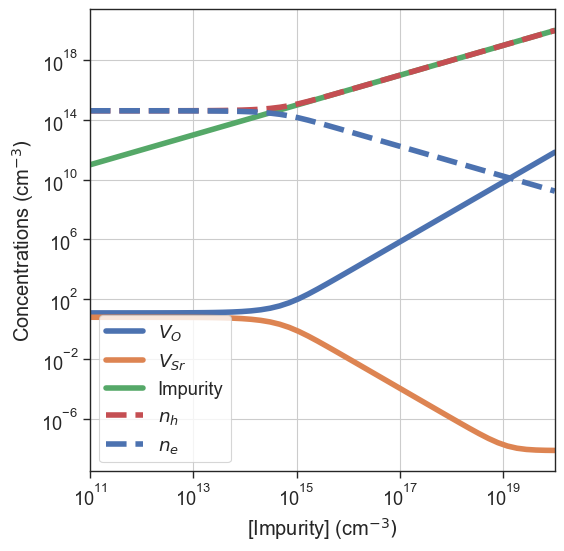

In [203]:
plt = da.plot_doping_diagram(
                        variable_defect_specie={'name':'Impurity','charge':-1},
                        concentration_range=(1e11,1e20),
                        chemical_potentials=chempots,
                        bulk_dos=bulk_dos,
                        temperature=1000,
                        figsize=(6,6));

# Defect quenching

When materials are synthesized at high temperature and then quickly cooled down, often the mobility of ionic defects is too low to reach thermodynamic equilibrium. However, electrons and holes are more mobile and can reach equilibrium. This means that the total concentration of ionic defects is approximately fixed to the high temperature value, but their charges states can change. To achieve this, we use the same approach as for dopants, described in the previous [link](https://link.aps.org/doi/10.1103/PhysRevB.106.134101).\
We simulate quenching conditions by specifying the `quench_temperature` in the function arguments.

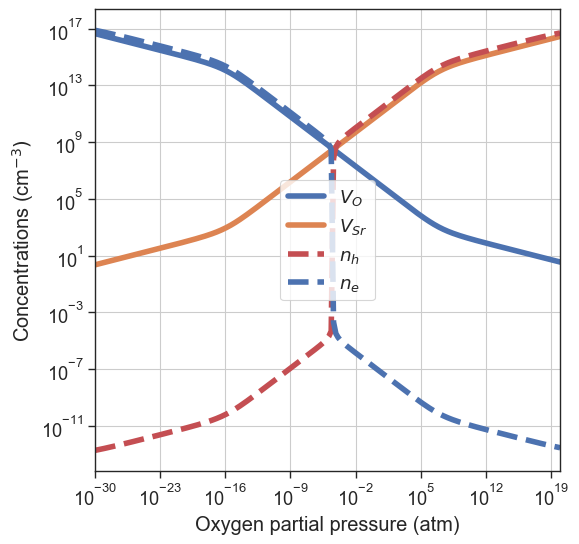

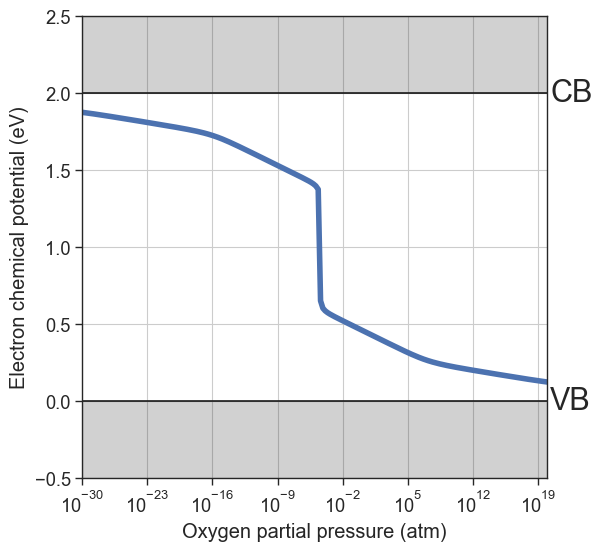

In [204]:
plt = da.plot_brouwer_diagram(
                        bulk_dos=bulk_dos,
                        temperature=1000,
                        quench_temperature=300,
                        precursors=precursors,
                        oxygen_ref=-4.95,
                        figsize=(6,6),
                        pressure_range=(1e-30,1e20),
                        npoints=200);
plt.show()

quenched_data = da.thermodata
plot_pO2_vs_fermi_level(
                    partial_pressures=quenched_data.partial_pressures,
                    fermi_levels=quenched_data.fermi_levels,
                    band_gap = da.band_gap,
                    figsize=(6,6),
                    xlim=(1e-30,1e20));

## Partial quenching

If one ionic defect is particularly mobile, we can assume its concentration will be equilibrated at lower temperature. For this reason, we can also specify which defect species to quench. In this example we'll consider $V_O$ more mobile, therefore we only quench $V_{Sr}$ by specifying `quenched_species=['Vac_Sr']`. 

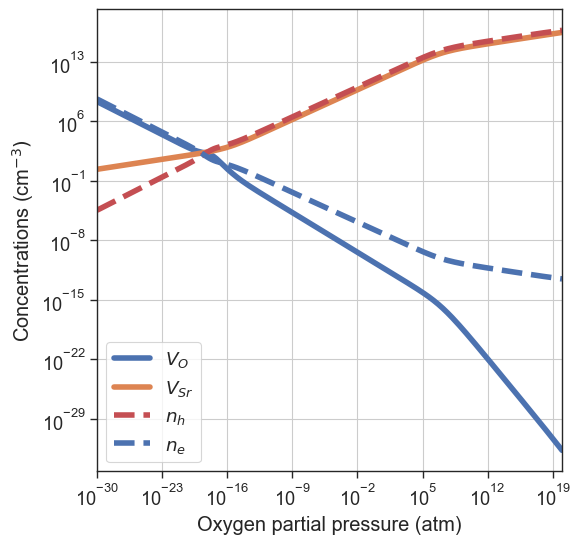

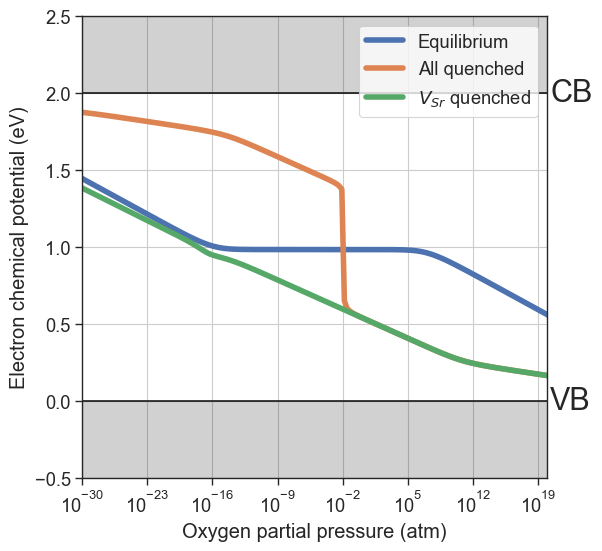

In [205]:
plt = da.plot_brouwer_diagram(
                        bulk_dos=bulk_dos,
                        temperature=1000,
                        quench_temperature=300,
                        quenched_species=['Vac_Sr'],
                        precursors=precursors,
                        oxygen_ref=-4.95,
                        figsize=(6,6),
                        pressure_range=(1e-30,1e20),
                        npoints=200);
plt.show()

partial_quenched_data = da.thermodata
fermi_levels = {
            'Equilibrium':data.fermi_levels,
            'All quenched':quenched_data.fermi_levels,
            '$V_{Sr}$ quenched':partial_quenched_data.fermi_levels
            }
plot_pO2_vs_fermi_level(
                    partial_pressures=data.partial_pressures,
                    fermi_levels=fermi_levels,
                    band_gap = da.band_gap,
                    figsize=(6,6),
                    xlim=(1e-30,1e20));

# Custom formation energies and defect concentrations

`defermi` offers the possibility to customize the core functions `DefectEntry.formation_energy` and `DefectEntry.defect_concentration`. This is especially useful whenever we want to simulate conditions that deviate from the standard ideal solution model, with temperature-independent formation energies, or anisotropic systems like interfaces and grain boundaries. For more detailed examples, refer to the **tutorials** on custom functions.\
In this example, we implement temperature-dependent formation energies for $V_O$. Let's assume we were able to calculate the dependency of the formation energy on temperature, and have found that $\Delta E_f$ descreases with temperature, with a discontinuity at 500 K due to a phase transition in the bulk material:

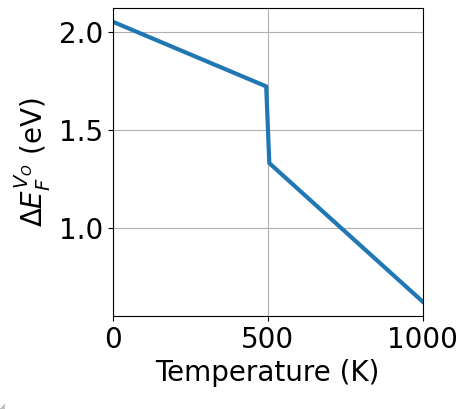

We can now define a function to compute the formation energy for this specific case. The function inputs need to be the same as the inputs of the default `formation_energy` function, plus the custom `**kwargs`:
- `entry` : `DefectEntry` object
- `vbm`
- `chemical_potentials`
- `fermi_level`
- `temperature`
- `**kwargs`

In this example, we compute the T-dependent formation energy as:
$$ \Delta E_f (T) = \Delta E_f (0 \mathrm{K}) + E_{shift} (T) $$

In [206]:
# T-dependent formation energy
def custom_formation_energy(
                entry,
                vbm=None,
                chemical_potentials=None,
                fermi_level=0,
                temperature=0,
                **kwargs):
        
        formation_energy = entry.energy_diff + entry.charge*(vbm+fermi_level) 
        if chemical_potentials:
            chempot_correction = -1 * sum([entry.delta_atoms[el]*chemical_potentials[el] for el in entry.delta_atoms])
        else:
            chempot_correction = 0
            
        formation_energy = formation_energy + chempot_correction
        if temperature < 500:
            temperature_correction = - 1/1500 *temperature
        else:
            temperature_correction = - 1/700 *temperature
        return formation_energy + temperature_correction       

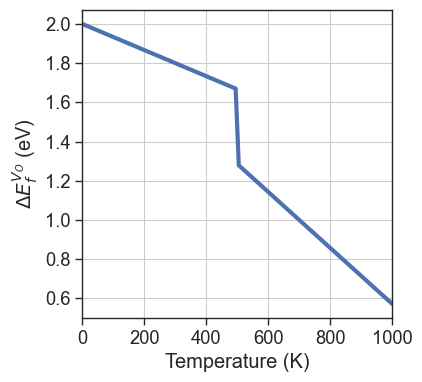

In [211]:
import numpy as np

X = np.linspace(0,1000,100)
entry = da.select_entries(name='Vac_O',charge=2)[0]
Y = [custom_formation_energy(entry=entry,vbm=0,chemical_potentials=chempots,fermi_level=0,temperature=x) for x in X]
plt.figure(figsize=(4,4))
plt.plot(X,Y,lw=3)
plt.xlabel('Temperature (K)')
plt.ylabel('$\Delta E_f^{V_O}$ (eV)')
plt.xlim(0,1000);
plt.grid();

Once the function is defined, we can set the `DefectEntry.formation_energy` function in the desired defects to our custom function, using the `set_formation_energy_functions` method, direclty by using `DefectEntry.set_formation_energy_function` for the individual entry.

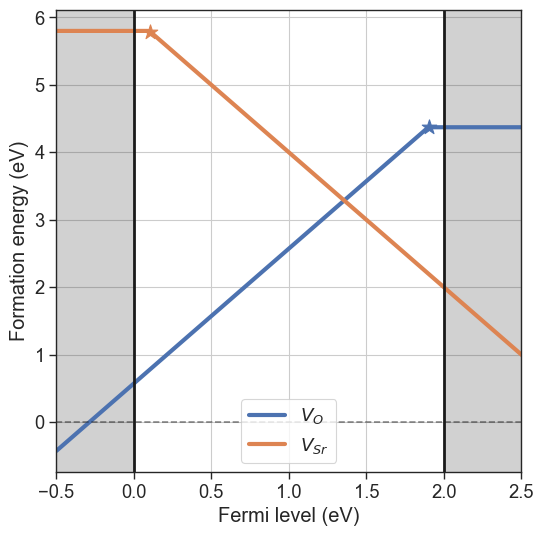

In [208]:
da.set_formation_energy_functions(function=custom_formation_energy,name='Vac_O')

# formation energies computed with cuatom function for Vac_O
da.plot_formation_energies(chempots,temperature=1000);

All subsequent calculations will call our custom function for the desired defect. The default behaviour can be reset with `reset_formation_energy_functions`.

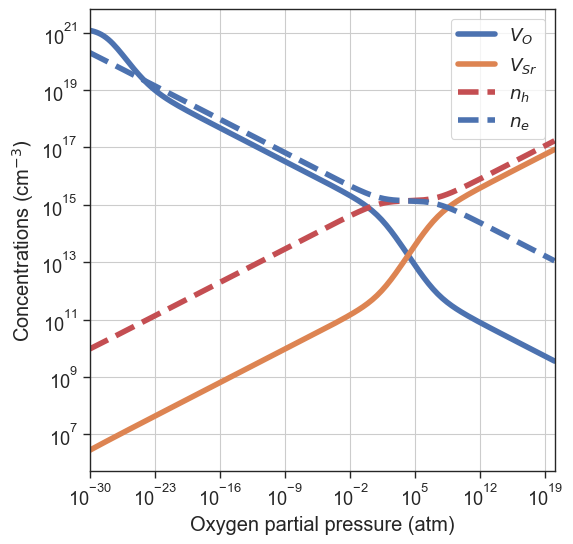

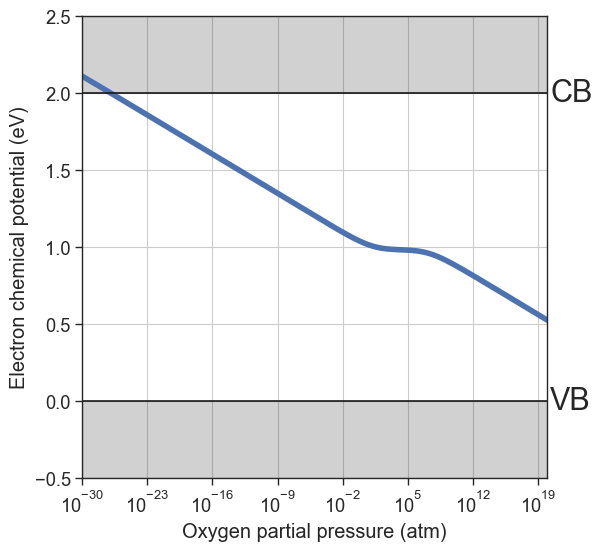

In [209]:
plt = da.plot_brouwer_diagram(
                        bulk_dos=bulk_dos,
                        temperature=1100,
                        precursors=precursors,
                        oxygen_ref=-4.95,
                        figsize=(6,6),
                        pressure_range=(1e-30,1e20),
                        npoints=200);
plt.show()

data = da.thermodata
plot_pO2_vs_fermi_level(
                    partial_pressures=data.partial_pressures,
                    fermi_levels=data.fermi_levels,
                    band_gap = da.band_gap,
                    figsize=(6,6),
                    xlim=(1e-30,1e20));